# Testing Notebook - Regression Tree

TODO:
- [ ] create random regressions datasets for testing
- [ ] run training and prediction on these datasets and collect statistics
- [ ] same as 3 but with the scikit regression tree
- [ ] try a bunch of different settings, most likely use grid search with cross validation
- [ ] visualize the results

In [40]:
from scripts.regression_tree import RegressionTree
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.datasets import make_regression
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


RANDOM_STATE = 42

## Helper functions

In [57]:
"""Generate synthetic regression data using scikit-learn's make_regression function."""
def generate_regression_data(n_samples=100, n_features=1, noise=0.1, random_state=RANDOM_STATE):
  X, y = make_regression(n_samples=n_samples, n_features=n_features, noise=noise, random_state=random_state)
  print("Generated regression data with {} samples and {} features.".format(n_samples, n_features))
  print("First 5 samples of X:\n", X[:5])
  print("First 5 samples of y:\n", y[:5])
  return X, y

"""Evaluate a regression model using cross-validation and return performance metrics."""
def evaluate_model(model, X, y, cv=5):
    cv_results = cross_validate(
        model,
        X,
        y,
        cv=cv,
        scoring=["r2", "neg_mean_squared_error", "neg_mean_absolute_error"],
        return_train_score=False,
    )

    return {
        "r2_mean": np.mean(cv_results["test_r2"]),
        "r2_std":  np.std(cv_results["test_r2"]),
        "mse_mean": -np.mean(cv_results["test_neg_mean_squared_error"]),
        "mae_mean": -np.mean(cv_results["test_neg_mean_absolute_error"]),
    }

## Definition of testing configurations

In [58]:
TESTING_CONFIGS = [
  {
    "description": "Basic regression data with low noise",
    "n_samples": 100,
    "n_features": 1,
    "noise": 0.1
  },
  {
    "description": "Regression data with higher noise",
    "n_samples": 100,
    "n_features": 1,
    "noise": 10.0
  },
  {
    "description": "Regression data with multiple features",
    "n_samples": 200,
    "n_features": 5,
    "noise": 5.0
  },
  {
    "description": "Larger dataset with moderate noise",
    "n_samples": 5000,
    "n_features": 3,
    "noise": 2.0
  },
  {
    "description": "Large dataset with low noise",
    "n_samples": 10000,
    "n_features": 2,
    "noise": 0.5
  },
  {
    "description": "Large dataset with high noise",
    "n_samples": 10000,
    "n_features": 2,
    "noise": 20.0
  },
  {
    "description": "Moderate dataset with many features",
    "n_samples": 1000,
    "n_features": 50,
    "noise": 5.0
  }
]

HYPERPARAM_CONFIGS = [
    {
        "name": "shallow",
        "max_depth": 2,
        "min_samples_leaf": 1,
        "min_samples_split": 2,
    },
    {
        "name": "medium",
        "max_depth": 4,
        "min_samples_leaf": 1,
        "min_samples_split": 2,
    },
    {
        "name": "deep",
        "max_depth": 8,
        "min_samples_leaf": 1,
        "min_samples_split": 2,
    },
    {
        "name": "unrestricted",
        "max_depth": None,
        "min_samples_leaf": 1,
        "min_samples_split": 2,
    },
    {
        "name": "regularized_leaf",
        "max_depth": None,
        "min_samples_leaf": 5,
        "min_samples_split": 2,
    },
    {
        "name": "strongly_regularized",
        "max_depth": None,
        "min_samples_leaf": 10,
        "min_samples_split": 10,
    },
]

## Runing the tests

For each configuration we will train the scikit-learn's built-in regression tree model as well as our implementation, we collect useful statistics and compare them.

In [59]:
results = []

for config in TESTING_CONFIGS:
    print("=" * 80)
    print(f"Dataset: {config['description']}")
    print("=" * 80)

    X, y = generate_regression_data(
        n_samples=config["n_samples"],
        n_features=config["n_features"],
        noise=config["noise"],
    )

    for hp in HYPERPARAM_CONFIGS:
        print("-" * 80)
        print(f"Hyperparams: {hp['name']}")

        model_specs = [
            (
                "our",
                RegressionTree(
                    max_depth=hp["max_depth"],
                    min_samples_leaf=hp["min_samples_leaf"],
                    min_samples_split=hp["min_samples_split"],
                ),
            ),
            (
                "sklearn",
                DecisionTreeRegressor(
                    max_depth=hp["max_depth"],
                    min_samples_leaf=hp["min_samples_leaf"],
                    min_samples_split=hp["min_samples_split"],
                ),
            ),
        ]

        for model_name, model in model_specs:
            metrics = evaluate_model(model, X, y)

            print(
                f"{model_name:8s} | "
                f"R²: {metrics['r2_mean']:.3f} ± {metrics['r2_std']:.3f} | "
                f"MSE: {metrics['mse_mean']:.3f} | "
                f"MAE: {metrics['mae_mean']:.3f}"
            )

            results.append({
                "dataset": config["description"],
                "hyperparams": hp["name"],
                "model": model_name,
                **metrics,
            })

Dataset: Basic regression data with low noise
Generated regression data with 100 samples and 1 features.
First 5 samples of X:
 [[ 0.93128012]
 [ 0.08704707]
 [-1.05771093]
 [ 0.31424733]
 [-0.47917424]]
First 5 samples of y:
 [ 38.9917296    3.4964533  -44.05770173  13.09112657 -19.9786311 ]
--------------------------------------------------------------------------------
Hyperparams: shallow
our      | R²: 0.885 ± 0.029 | MSE: 159.505 | MAE: 10.251
sklearn  | R²: 0.885 ± 0.029 | MSE: 159.505 | MAE: 10.251
--------------------------------------------------------------------------------
Hyperparams: medium
our      | R²: 0.987 ± 0.006 | MSE: 19.322 | MAE: 3.020
sklearn  | R²: 0.987 ± 0.006 | MSE: 19.322 | MAE: 3.020
--------------------------------------------------------------------------------
Hyperparams: deep
our      | R²: 0.994 ± 0.008 | MSE: 10.395 | MAE: 1.420
sklearn  | R²: 0.994 ± 0.008 | MSE: 10.395 | MAE: 1.420
----------------------------------------------------------------

## Results

In [64]:
df = pd.DataFrame(results)
paired = (
    df.pivot_table(
        index=["dataset", "hyperparams"],
        columns="model",
        values=["r2_mean", "mse_mean", "mae_mean"]
    )
)

paired.columns = ["_".join(col) for col in paired.columns]
paired = paired.reset_index()

paired["r2_diff"]  = paired["r2_mean_our"]  - paired["r2_mean_sklearn"]
paired["mse_diff"] = paired["mse_mean_our"] - paired["mse_mean_sklearn"]
paired["mae_diff"] = paired["mae_mean_our"] - paired["mae_mean_sklearn"]

paired.head()

,dataset,hyperparams,mae_mean_our,mae_mean_sklearn,mse_mean_our,mse_mean_sklearn,r2_mean_our,r2_mean_sklearn,r2_diff,mse_diff,mae_diff
0,Basic regression data with low noise,deep,1.420082,1.420082,10.395394,10.395394,0.993668,0.993668,0.0,0.000000e+00,0.000000e+00
1,Basic regression data with low noise,medium,3.019620,3.019620,19.322168,19.322168,0.986635,0.986635,0.0,0.000000e+00,0.000000e+00
2,Basic regression data with low noise,regularized_leaf,4.271927,4.271927,45.194549,45.194549,0.971219,0.971219,0.0,2.131628e-14,1.776357e-15
3,Basic regression data with low noise,shallow,10.251087,10.251087,159.505327,159.505327,0.884677,0.884677,0.0,-5.684342e-14,1.776357e-15
4,Basic regression data with low noise,strongly_regularized,8.168215,8.168215,124.116470,124.116470,0.913597,0.913597,0.0,0.000000e+00,0.000000e+00


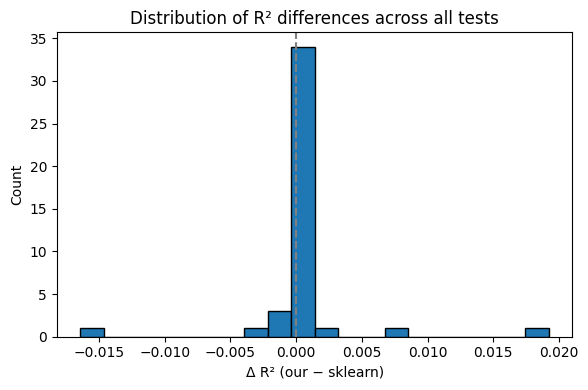

In [66]:
plt.figure(figsize=(6, 4))
plt.hist(paired["r2_diff"], bins=20, edgecolor="black")
plt.axvline(0, linestyle="--", color="gray")
plt.xlabel("Δ R² (our − sklearn)")
plt.ylabel("Count")
plt.title("Distribution of R² differences across all tests")
plt.tight_layout()
plt.show()

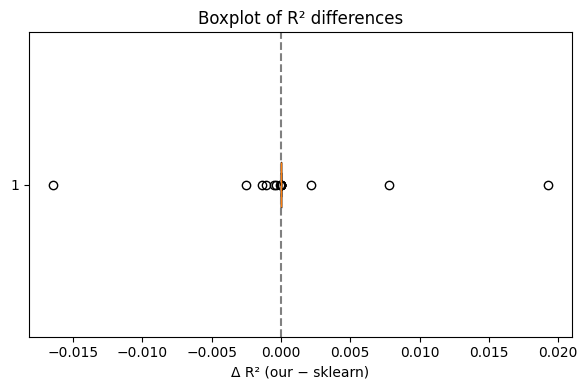

In [67]:
plt.figure(figsize=(6, 4))
plt.boxplot(
    paired["r2_diff"],
    vert=False,
    showfliers=True
)
plt.axvline(0, linestyle="--", color="gray")
plt.xlabel("Δ R² (our − sklearn)")
plt.title("Boxplot of R² differences")
plt.tight_layout()
plt.show()

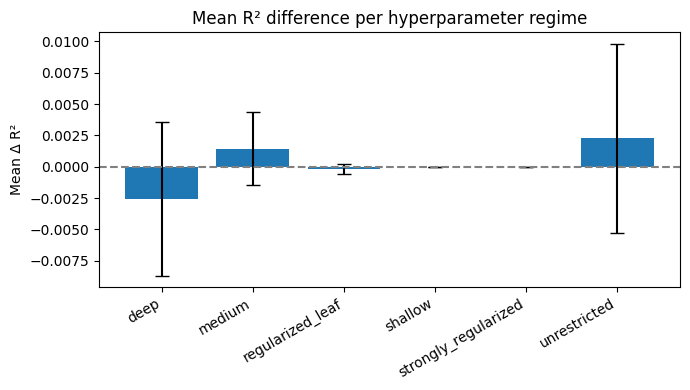

In [69]:
by_hp = (
    paired.groupby("hyperparams")["r2_diff"]
    .agg(["mean", "std"])
    .reset_index()
)

plt.figure(figsize=(7, 4))
plt.bar(
    by_hp["hyperparams"],
    by_hp["mean"],
    yerr=by_hp["std"],
    capsize=5
)
plt.axhline(0, linestyle="--", color="gray")
plt.ylabel("Mean Δ R²")
plt.title("Mean R² difference per hyperparameter regime")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()

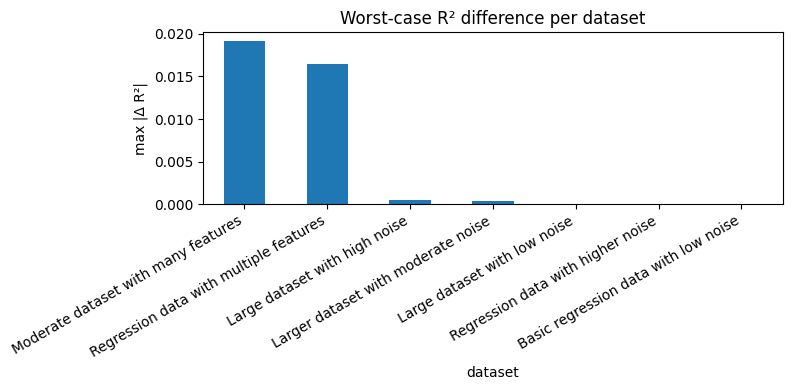

In [70]:
worst_by_dataset = (
    paired.groupby("dataset")["r2_diff"]
    .apply(lambda x: x.abs().max())
    .sort_values(ascending=False)
)

plt.figure(figsize=(8, 4))
worst_by_dataset.plot(kind="bar")
plt.ylabel("max |Δ R²|")
plt.title("Worst-case R² difference per dataset")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()

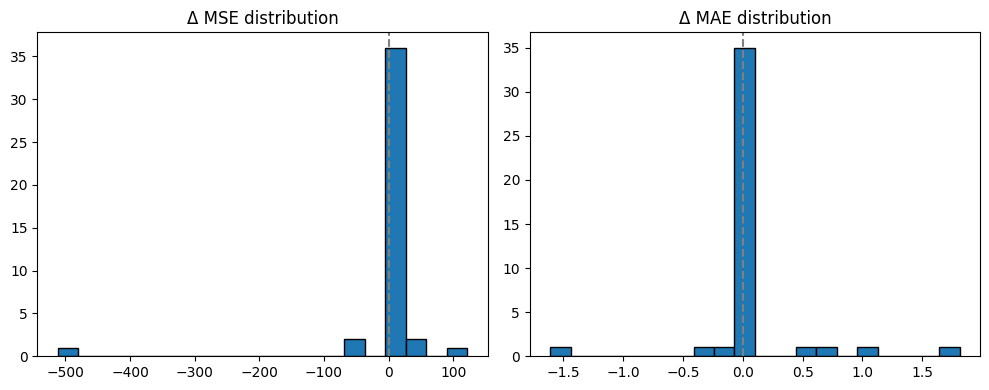

In [71]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].hist(paired["mse_diff"], bins=20, edgecolor="black")
axes[0].axvline(0, linestyle="--", color="gray")
axes[0].set_title("Δ MSE distribution")

axes[1].hist(paired["mae_diff"], bins=20, edgecolor="black")
axes[1].axvline(0, linestyle="--", color="gray")
axes[1].set_title("Δ MAE distribution")

plt.tight_layout()
plt.show()